## Randomized Classifier

This is a random classifier meant to act as a baseline to compare our methods

In [24]:
import pandas as pd
import numpy as np
import json
import os
from tqdm import tqdm
from functools import partial
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Loading the data and preprocessing
Here we, load the dataframe, create the labels and then also create the spltis

In [25]:
data_dir = '../data/MMHS150K'
df = pd.read_json(os.path.join(data_dir, 'MMHS150K_GT.json'),\
                  lines=False, orient='index', convert_dates=False)

df = df.reset_index()

df['id'] = df['tweet_url'].str.extract(r'/status/(\d+)')

df['img'] = 'img_resized/'+df['id']+'.jpg'

# Folder containing the JSON files
json_folder = os.path.join(data_dir,'img_txt')

# Function to load "img_text" from a given ID's JSON file
def load_img_text(row_id):
    file_path = os.path.join(json_folder, f"{row_id}.json")
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            return data.get("img_text", None)
    except Exception as e:
        # print(f"Warning: Could not read {file_path} — {e}")
        return None

tqdm.pandas(desc="Processing...")
# Apply the function to the 'id' column to create a new column
df['img_text'] = df['id'].progress_apply(load_img_text)

def label_agg(row):
    res = 0
    for x in row:
        if x != 0:
            res+= 1
    return res

df['label'] = df['labels'].progress_apply(label_agg)

MM_df = df[['img', 'img_text','tweet_text','label','id']].copy()

Processing...: 100%|██████████| 149823/149823 [00:00<00:00, 386223.86it/s]


Building Train set: 134823it [00:00, 655670.94it/s]
Building Val set: 5000it [00:00, 1328656.87it/s]


Probability is [0.38666293 0.3665859  0.18952364 0.05722753]
MAE: 1.1112
RMSE: 1.4078352176302453
Accuracy (Hate Score) 0.2666
Cohen's Kappa: -0.001975479225444297
Accuracy Soft: 0.491
F1: 0.5976284584980237


/tmp/ipykernel_8337/831077843.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['pred_label'] = random_classifier(len(validation_df), probs, label_classes=[0, 1, 2, 3])


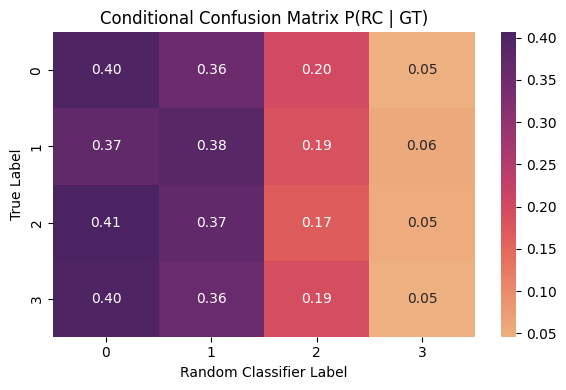

In [29]:
with open(f"{data_dir}/splits/train_ids.txt", 'r') as f:
    train_ids = set(line.strip() for line in tqdm(f, desc="Building Train set"))

with open(f"{data_dir}/splits/val_ids.txt", 'r') as f:
    val_ids = set(line.strip() for line in tqdm(f, desc="Building Val set"))


training_df = MM_df[MM_df['id'].isin(train_ids)]
validation_df = MM_df[MM_df['id'].isin(val_ids)]

counts = df['label'].value_counts().sort_index()
probs = counts.values / counts.sum()
print(f"Probability is {probs}")
assert probs.sum() == 1.0, "The probabilities do not sum to 1"

def random_classifier(num_samples, prob, label_classes):
    return np.random.choice(label_classes, (num_samples, 1), p=prob)


validation_df['pred_label'] = random_classifier(len(validation_df), probs, label_classes=[0, 1, 2, 3])

cm = confusion_matrix(validation_df['label'].values, validation_df['pred_label'].values, labels=[0, 1, 2, 3])
cm_nrm = confusion_matrix(validation_df['label'].values, validation_df['pred_label'].values, normalize='true', labels=[0, 1, 2, 3])

soft_acc_cm = confusion_matrix(validation_df['label'].values >=2, validation_df['pred_label'].values >=2)

observed_agreement = np.trace(cm) / len(validation_df)
row_marginals = np.sum(cm, axis=1)
col_marginals = np.sum(cm, axis=0)
expected_agreement = np.sum((row_marginals * col_marginals)) / (len(validation_df) ** 2)
print(f"MAE: {np.mean(np.abs(validation_df['label'].values - validation_df['pred_label'].values))}")
print(f"RMSE: {np.sqrt(np.mean((validation_df['label'].values - validation_df['pred_label'].values)**2))}")
print(f"Accuracy (Hate Score) {np.sum(validation_df["label"].values == validation_df["pred_label"])/len(validation_df)}")
print(f"Cohen's Kappa: {(observed_agreement - expected_agreement) / (1-expected_agreement)}")
print(f"Accuracy Soft: {np.trace(soft_acc_cm / len(validation_df))}")
print(f"F1: {soft_acc_cm[0, 0] / (soft_acc_cm[0, 0] + 0.5*(soft_acc_cm[1, 0] + soft_acc_cm[0, 1]))}")



plt.figure(figsize=(6, 4))
sns.heatmap(cm_nrm, annot=True, cmap="flare", fmt=".2f", cbar=True)
plt.title("Conditional Confusion Matrix P(RC | GT)")
plt.ylabel("True Label")
plt.xlabel("Random Classifier Label")
plt.tight_layout()
plt.savefig("random_classifier_CM.png")
plt.show()

